In [1]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;}</style>')

In [2]:
%load_ext version_information
%version_information pandas

Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
Tue Mar 12 21:03:56 2019 PDT

# Goalie Pull Bayes Optimize

 - Exploratory analysis

## Explore Parsed Goalie Pull Data

In [3]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 10
plt.style.use('ggplot')

def savefig(plt, name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

In [5]:
ls ../../data/processed/

csv/ pkl/


In [6]:
ls ../../data/processed/pkl

20032004_goalie_pulls_2019-03-01.pkl  20062007_goalie_pulls_2019-03-01.pkl
20052006_goalie_pulls_2019-03-01.pkl


In [7]:
def load_data():
    return pd.concat((
    pd.read_pickle('../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl'),
    pd.read_pickle('../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl'),
    pd.read_pickle('../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl'),
))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    return _df

In [8]:
df = load_data()
df = clean_df(df)

Removing goal_for_time < 15 mins
Removed 1 total rows


In [44]:
# Label the outcomes
df['label'] = ''
label_masks = {
    'goal_for': ~(df.goal_for_time.isnull()),
    'goal_against': ~(df.goal_against_time.isnull()),
    'no_goals': ~(df.game_end_timedelta.isnull()),   
}
for label, mask in label_masks.items():
    df.loc[mask, 'label'] = label
df.loc[df.label == '', 'label'] = float('nan')
df.label.isnull().sum()

0

In [9]:
df.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
0,20032004,710,CHI,2004-01-21,3,00:19:44,NaT,00:19:47,NaT,00:00:03,NaT
1,20032004,205,MIN,2003-11-08,3,00:19:58,NaT,NaT,NaT,NaT,00:00:02
2,20032004,1230,S.J,2004-04-04,3,00:18:39,00:19:40,NaT,00:01:01,NaT,NaT
3,20032004,655,PHX,2004-01-13,3,00:19:03,NaT,00:19:25,NaT,00:00:22,NaT
4,20032004,985,PHX,2004-03-02,3,00:18:34,00:18:44,NaT,00:00:10,NaT,NaT


In [10]:
df.tail()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
705,20062007,768,NYR,2007-01-31,3,00:19:42,NaT,NaT,NaT,NaT,00:00:18
706,20062007,787,CHI,2007-02-03,3,00:17:47,NaT,NaT,NaT,NaT,00:02:13
707,20062007,504,CHI,2006-12-20,3,00:18:40,NaT,NaT,NaT,NaT,00:01:20
708,20062007,154,STL,2006-10-28,3,00:18:31,NaT,NaT,NaT,NaT,00:01:29
709,20062007,1024,WSH,2007-03-10,3,00:18:40,NaT,00:19:11,NaT,00:00:31,NaT


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pull_period,2128,3,0,3,3,3,3,3
pull_time,2128,0 days 00:18:47.790883,0 days 00:00:41.230383,0 days 00:15:01,0 days 00:18:32,0 days 00:18:54,0 days 00:19:13,0 days 00:19:59
goal_for_time,270,0 days 00:19:07.329629,0 days 00:00:47.183248,0 days 00:15:37,0 days 00:18:50,0 days 00:19:19,0 days 00:19:39,0 days 00:19:59
goal_against_time,554,0 days 00:19:18.534296,0 days 00:00:34.599905,0 days 00:16:17,0 days 00:19:04.250000,0 days 00:19:25,0 days 00:19:44,0 days 00:19:59
goal_for_timedelta,270,0 days 00:00:33.525925,0 days 00:00:25.696637,0 days 00:00:00,0 days 00:00:14,0 days 00:00:30,0 days 00:00:47,0 days 00:02:26
goal_against_timedelta,554,0 days 00:00:38.348375,0 days 00:00:27.635111,0 days 00:00:00,0 days 00:00:17,0 days 00:00:31,0 days 00:00:53,0 days 00:02:30
game_end_timedelta,1305,0 days 00:01:06.078927,0 days 00:00:39.951647,0 days 00:00:01,0 days 00:00:42,0 days 00:01:00,0 days 00:01:21,0 days 00:04:59


In [12]:
df.dtypes

season                             object
game_number                        object
team_name                          object
date                       datetime64[ns]
pull_period                         int64
pull_time                 timedelta64[ns]
goal_for_time             timedelta64[ns]
goal_against_time         timedelta64[ns]
goal_for_timedelta        timedelta64[ns]
goal_against_timedelta    timedelta64[ns]
game_end_timedelta        timedelta64[ns]
dtype: object

In [13]:
df.isnull().sum() / df.shape[0]

season                    0.000000
game_number               0.000000
team_name                 0.000000
date                      0.000470
pull_period               0.000000
pull_time                 0.000000
goal_for_time             0.873120
goal_against_time         0.739662
goal_for_timedelta        0.873120
goal_against_timedelta    0.739662
game_end_timedelta        0.386748
dtype: float64

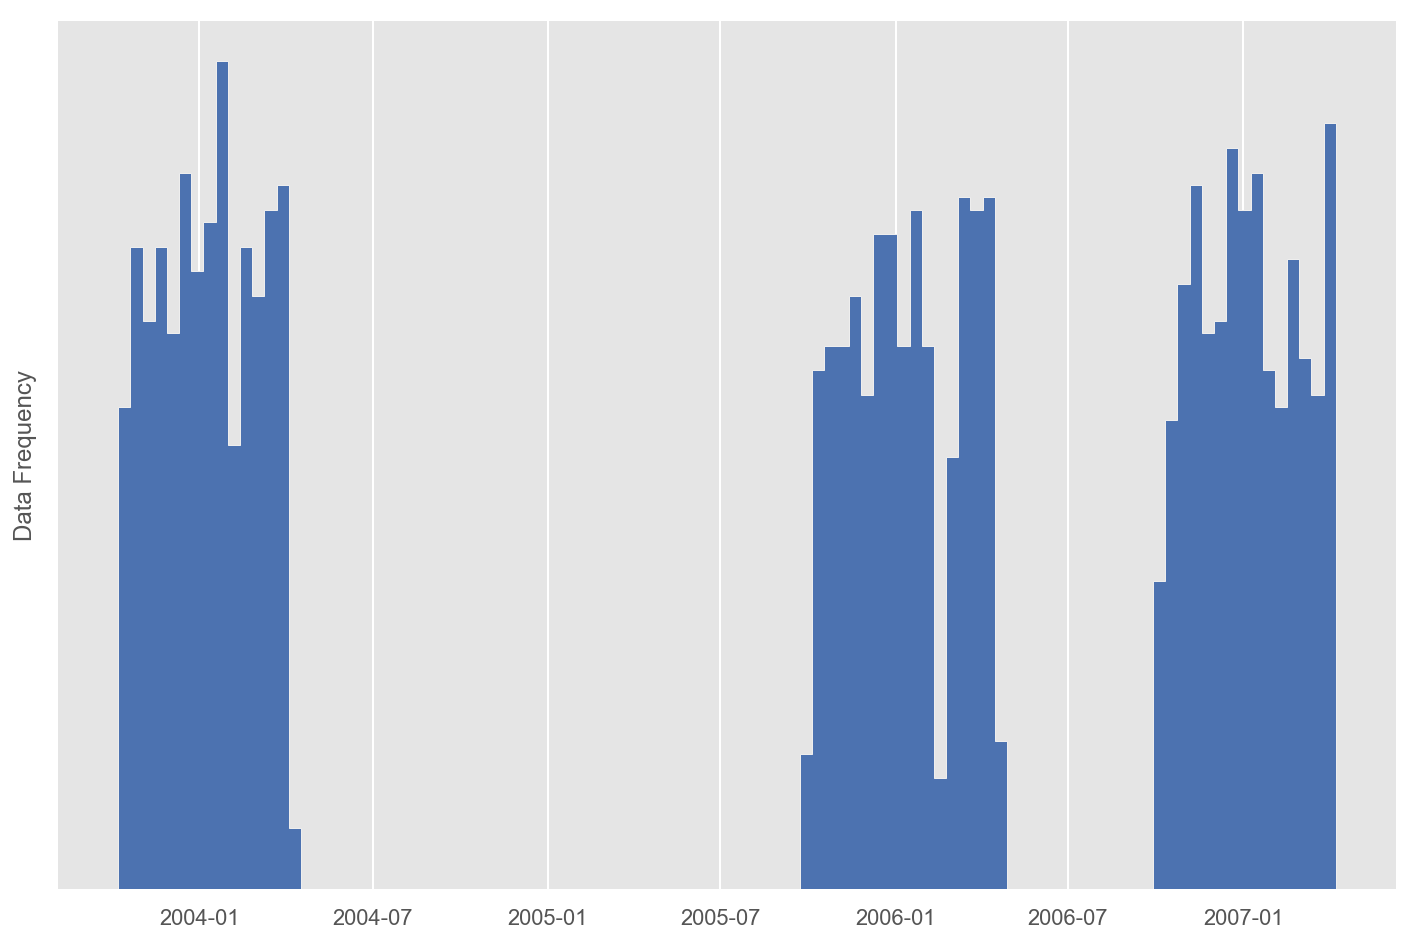

In [34]:
plt.ylabel('Data Frequency')
plt.yticks([])
df.date.hist(
    color='b',
    bins=100,
    histtype='stepfilled')
savefig(plt, 'date_distribution')

In [22]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'goal_for_timedelta',
       'goal_against_timedelta', 'game_end_timedelta'],
      dtype='object')

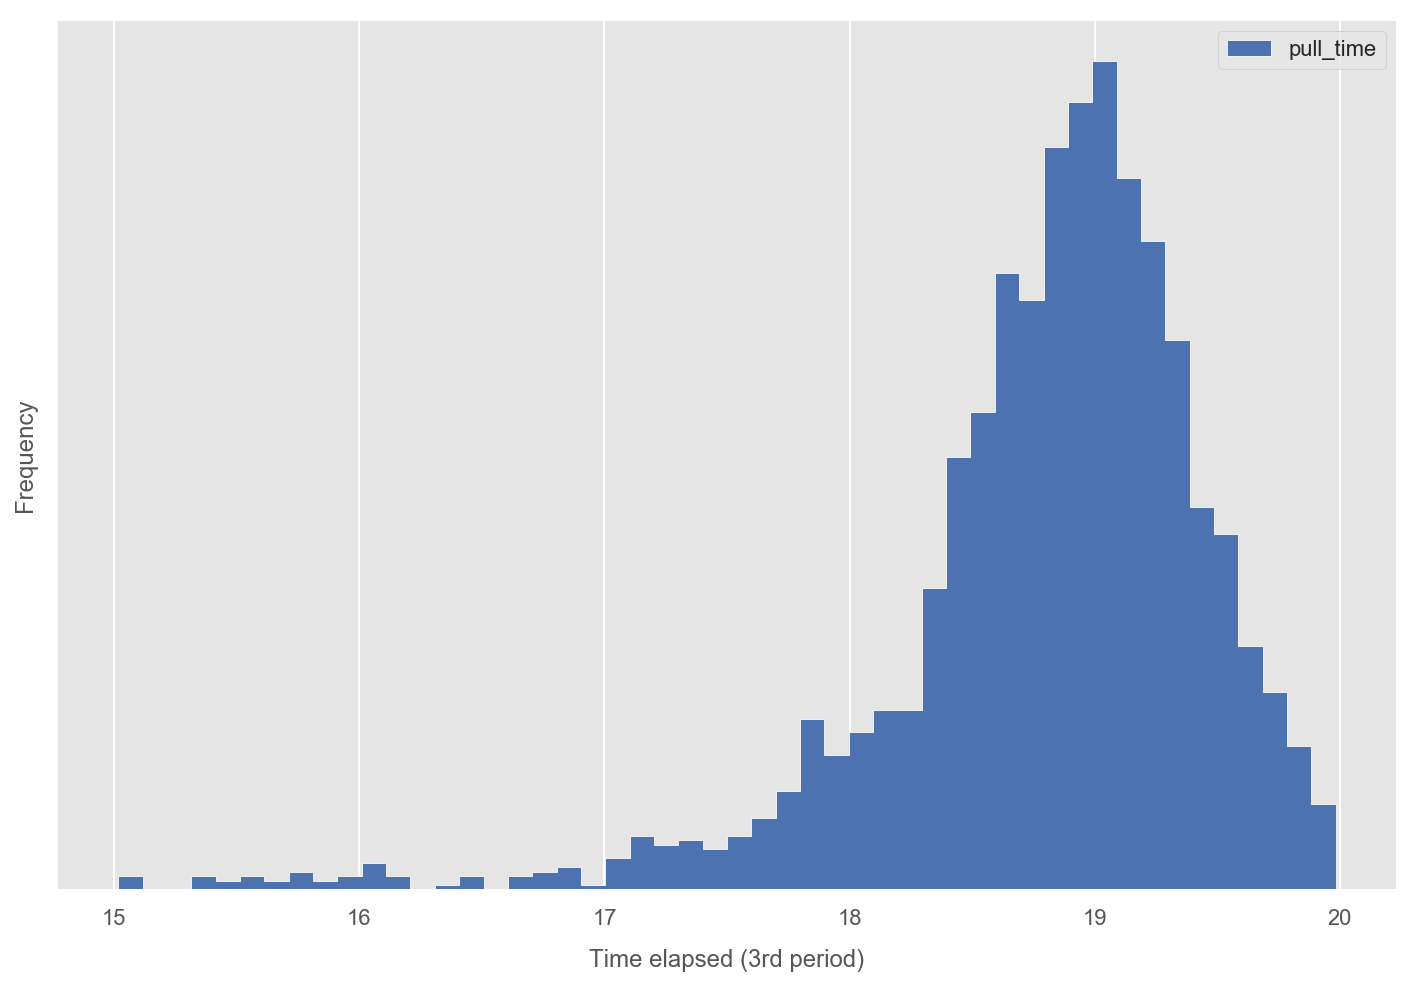

In [35]:
col = ['pull_time']
(df[col].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               color='b',
               histtype='stepfilled')
plt.xlabel(f'Time elapsed (3rd period)')
plt.yticks([])
savefig(plt, 'goalie_pull_game_times_hist')

We're interested in knowing about the outcome, given the pull time. This way we can look at the odds of scoring as a function of game time elapsed.

In [75]:
df.head()

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta,label,pull_time_seconds
0,20032004,710,CHI,2004-01-21,3,00:19:44,NaT,00:19:47,NaT,00:00:03,NaT,goal_against,19.733333
1,20032004,205,MIN,2003-11-08,3,00:19:58,NaT,NaT,NaT,NaT,00:00:02,no_goals,19.966667
2,20032004,1230,S.J,2004-04-04,3,00:18:39,00:19:40,NaT,00:01:01,NaT,NaT,goal_for,18.650000
3,20032004,655,PHX,2004-01-13,3,00:19:03,NaT,00:19:25,NaT,00:00:22,NaT,goal_against,19.050000
4,20032004,985,PHX,2004-03-02,3,00:18:34,00:18:44,NaT,00:00:10,NaT,NaT,goal_for,18.566667


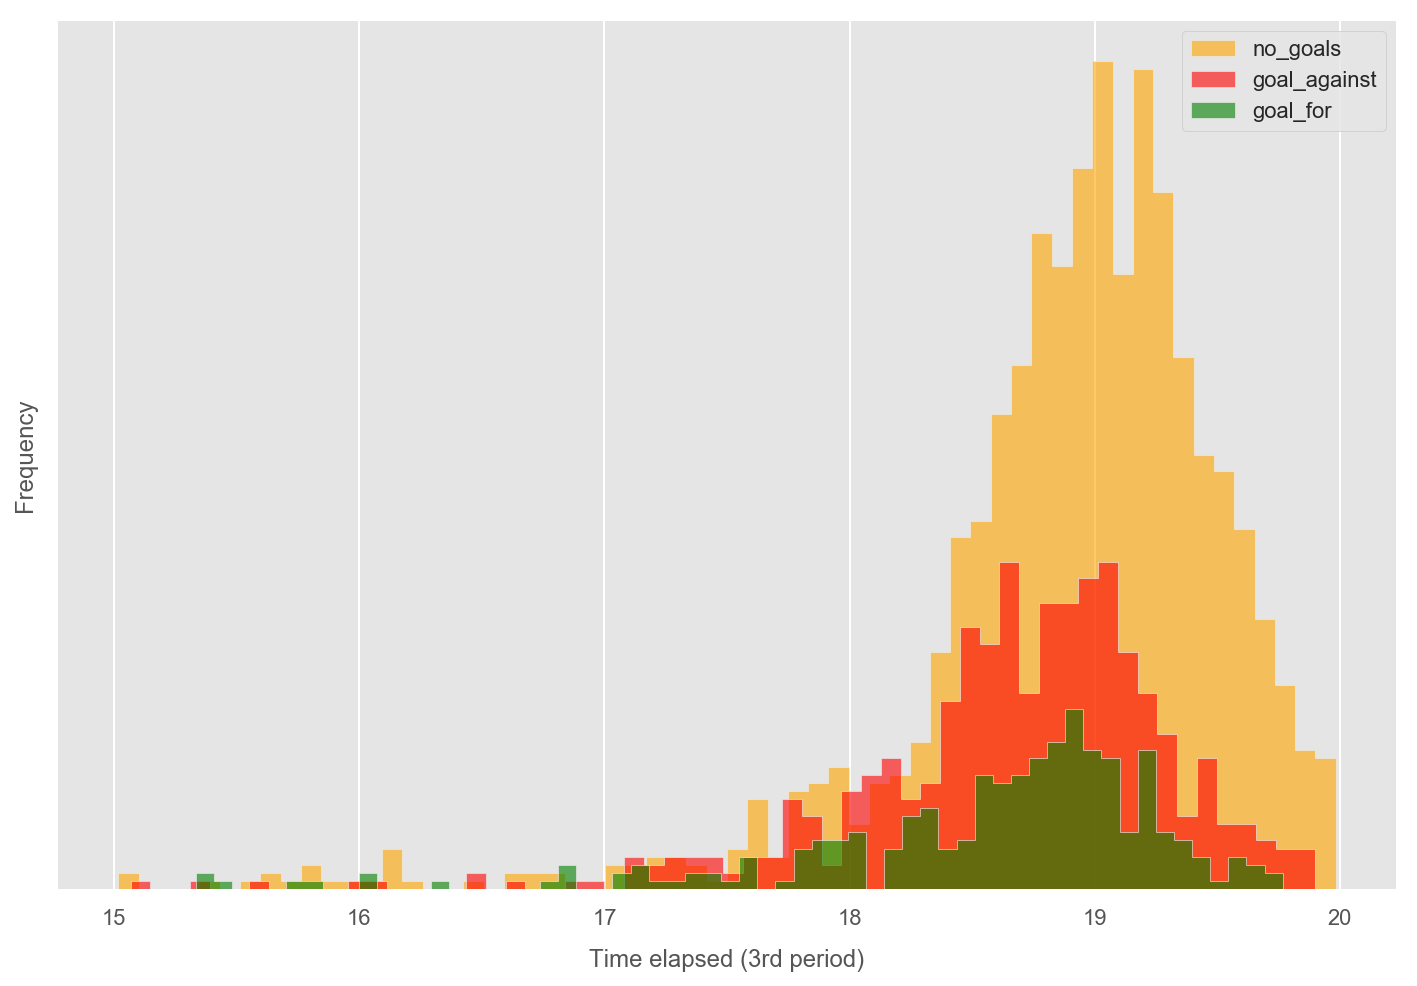

In [81]:
# ax = plt.subplot(111)
# ax.set_prop_cycle(color=['red', 'green', 'orange'])

df['pull_time_seconds'] = df['pull_time'].astype('timedelta64[s]') / 60

iterables = zip(['orange', 'red', 'green'],
                ['no_goals', 'goal_against', 'goal_for'])

for c, label in iterables:
    (df[df.label==label]['pull_time_seconds']
         .plot.hist(bins=60,
                    alpha=0.6,
                    color=c,
                    histtype='stepfilled',
                    label=label))

plt.xlabel(f'Time elapsed (3rd period)')
plt.yticks([])
plt.legend()

savefig(plt, 'goalie_pull_outcomes_game_times_hist')
del df['pull_time_seconds']

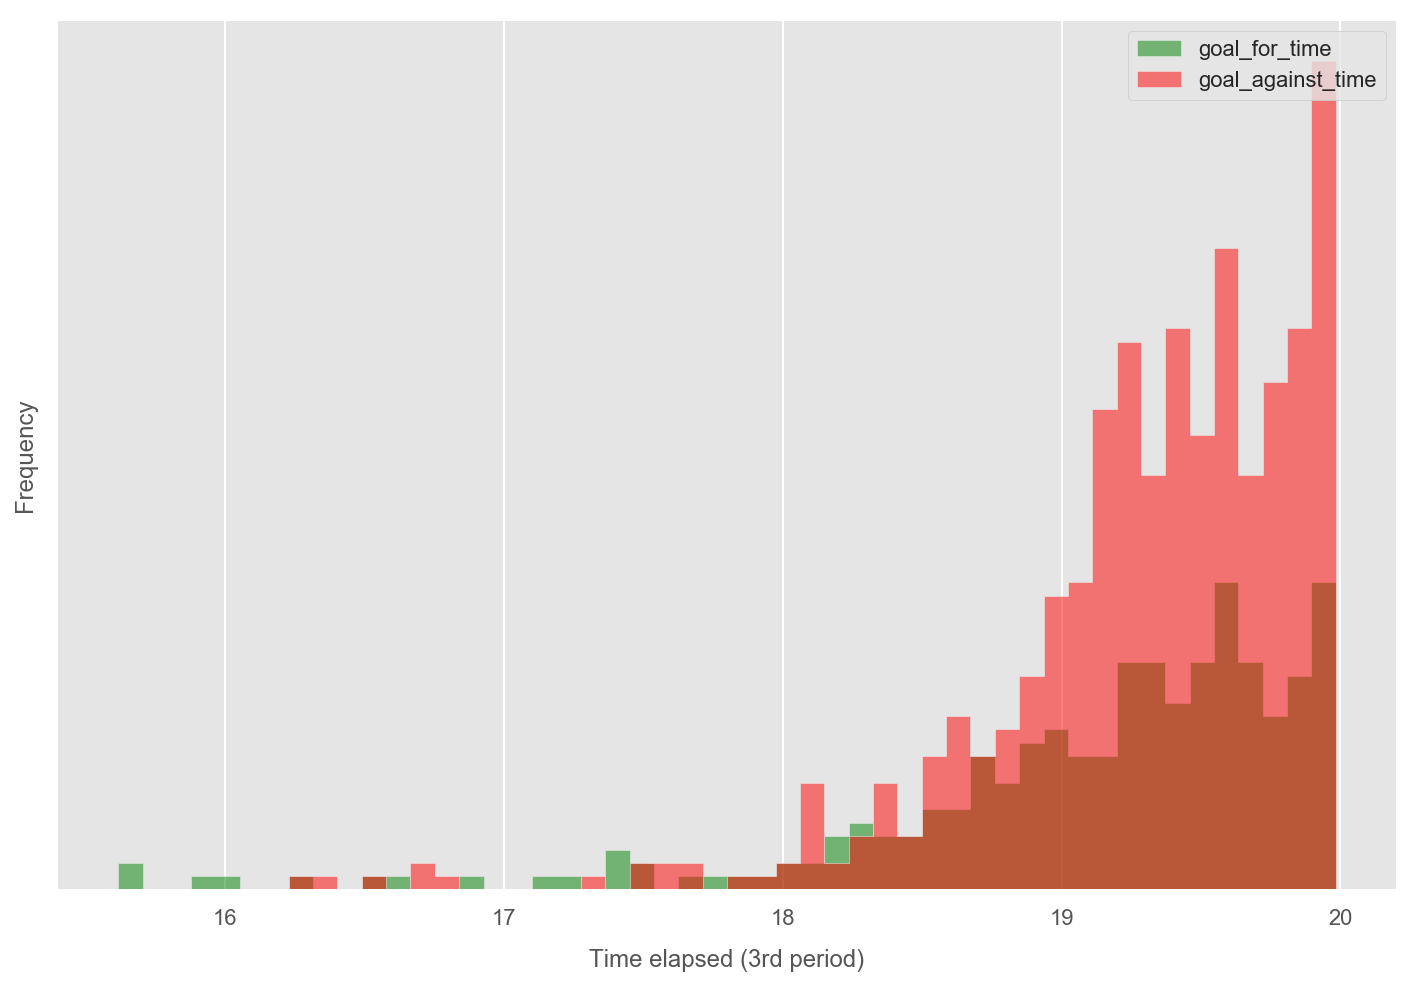

In [36]:
cols = ['goal_for_time', 'goal_against_time']
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               alpha=0.5,
               color=['green', 'red'],
               histtype='stepfilled')
plt.xlabel('Time elapsed (3rd period)')
plt.yticks([])
savefig(plt, '5_on_6_goals')

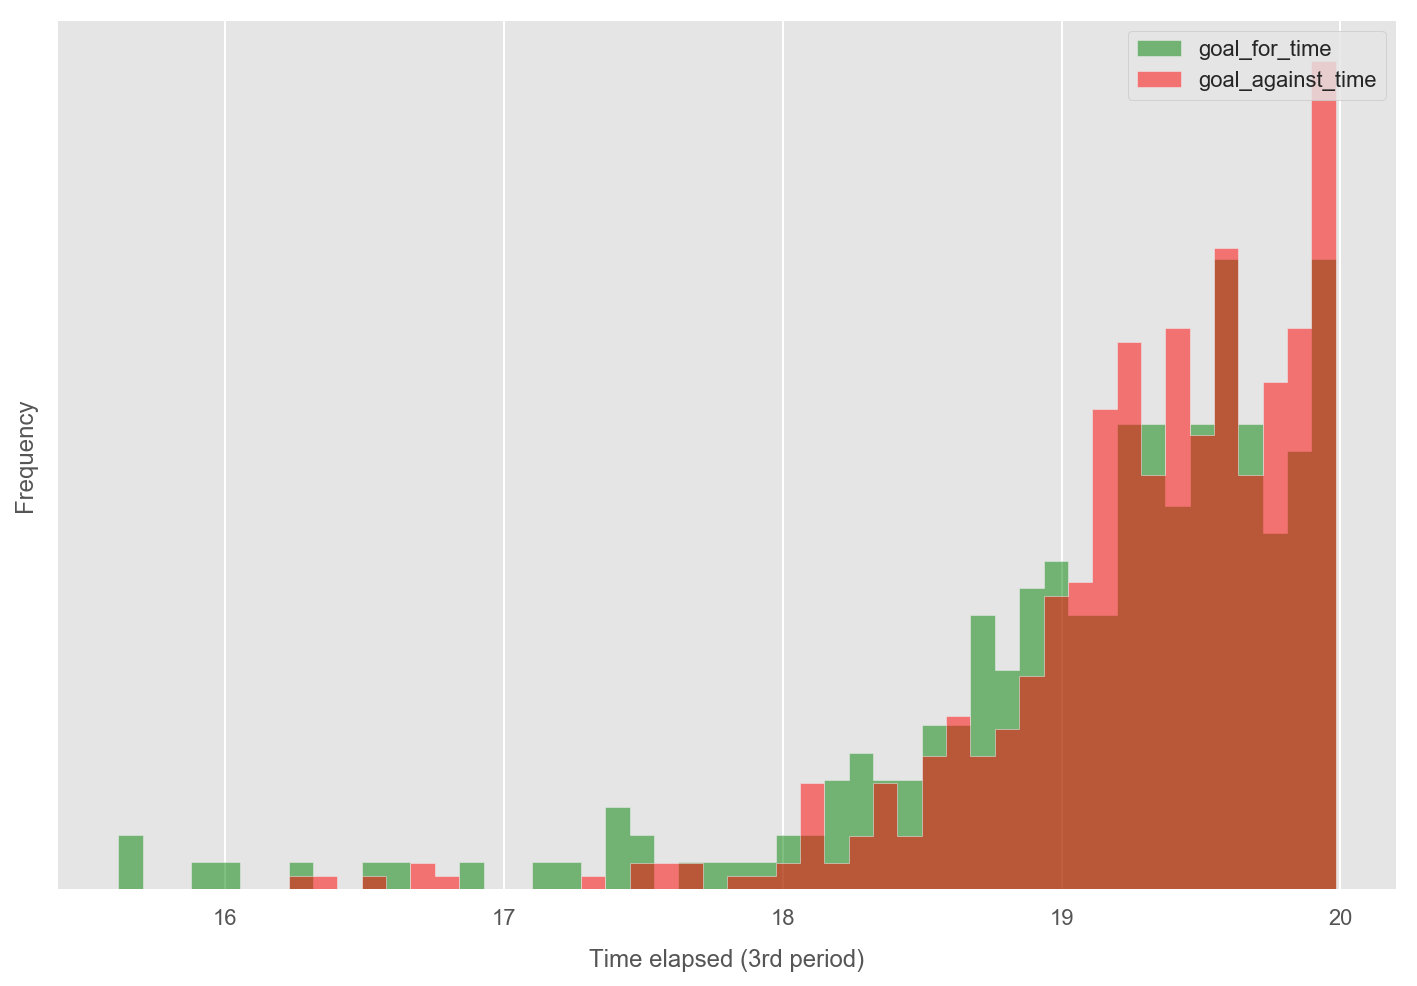

In [37]:
cols = ['goal_for_time', 'goal_against_time']
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50,
               alpha=0.5,
               density='normed',
               color=['green', 'red'],
               histtype='stepfilled')
plt.xlabel('Time elapsed (3rd period)')
plt.yticks([])
savefig(plt, '5_on_6_goals_normed')

In [38]:
print('Number of goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum()

Number of goals found:


goal_for_time        270
goal_against_time    554
dtype: int64

In [39]:
print('Total goals found:')
(~df[['goal_for_time', 'goal_against_time']].isnull()).sum().sum()

Total goals found:


824

We also want to model the time between goalie pull and goal (i.e. the timedelta).

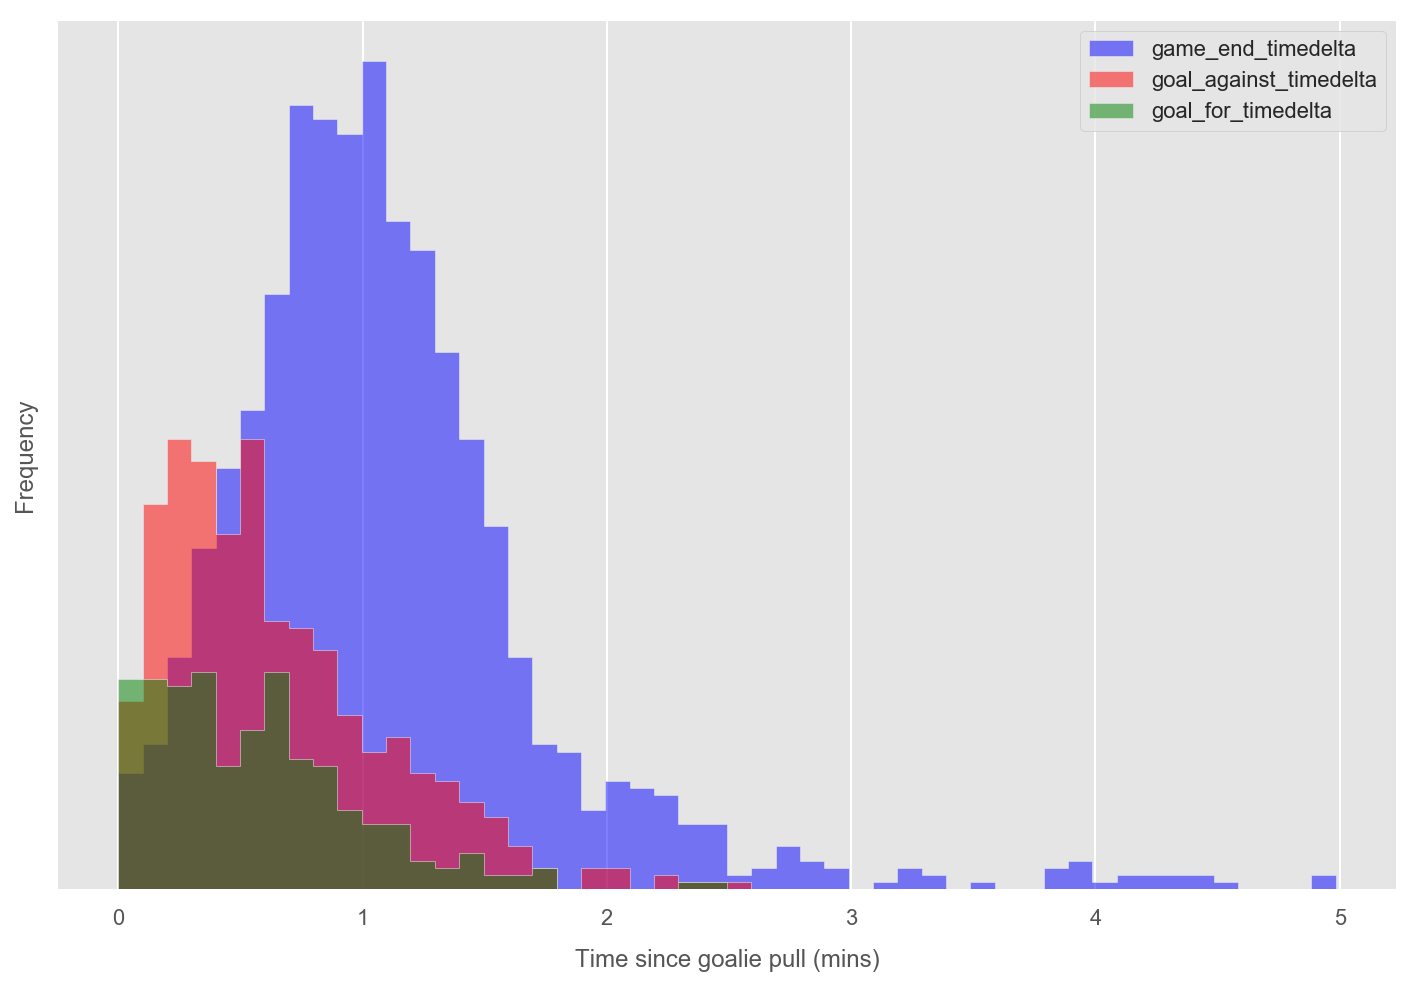

In [27]:
cols = ['game_end_timedelta', 'goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               color=['blue', 'red','green'],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (mins)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_outcomes')

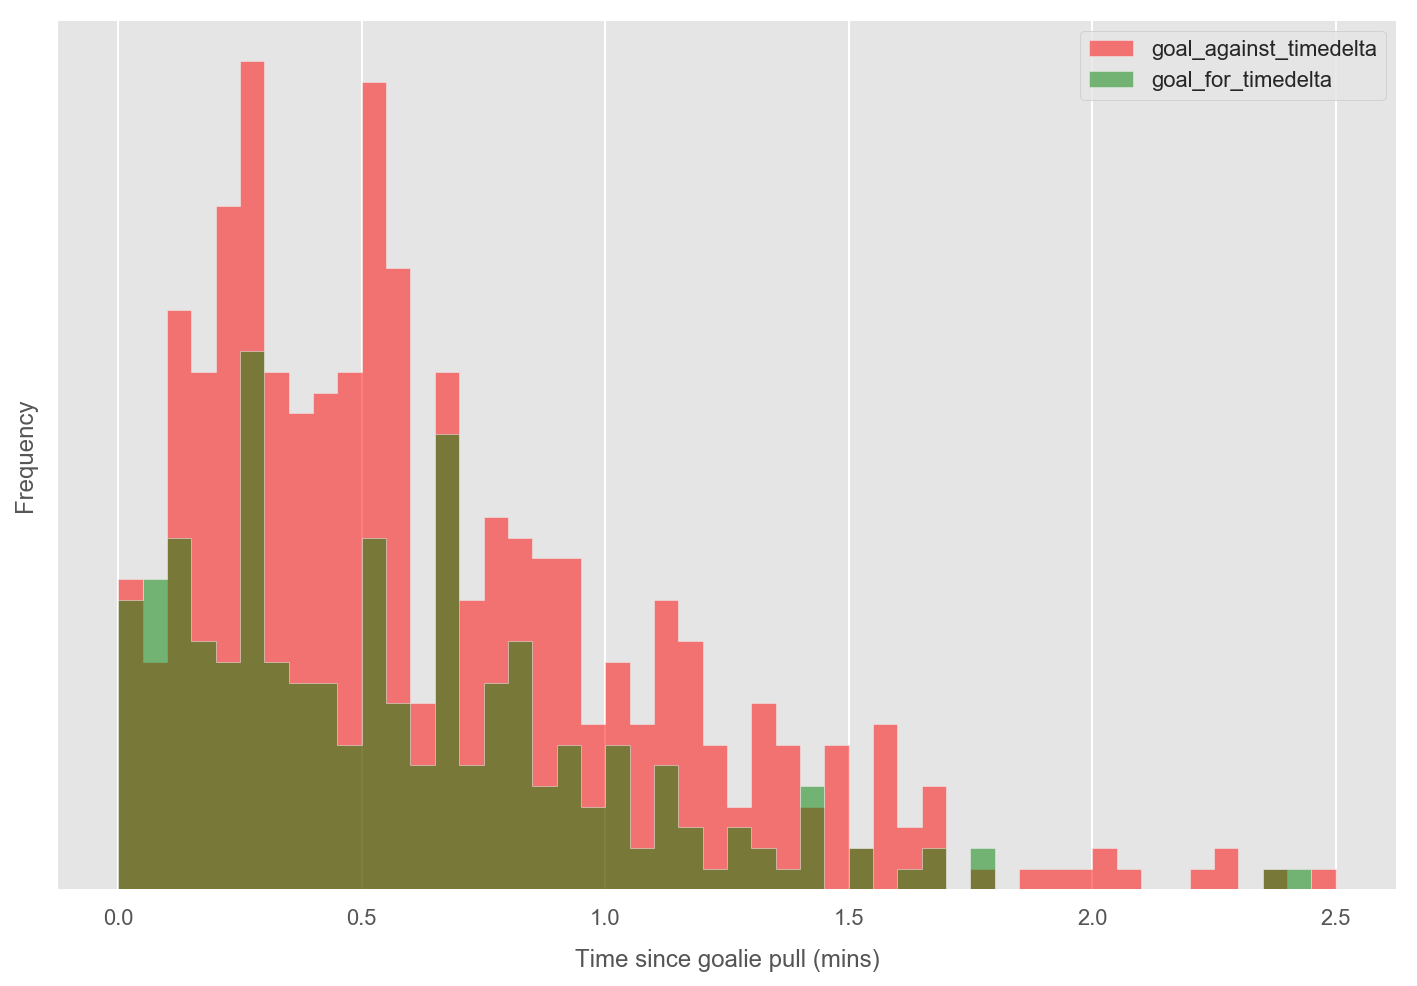

In [28]:
cols = ['goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               color=['red', 'green',],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (mins)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_goal_timedeltas')

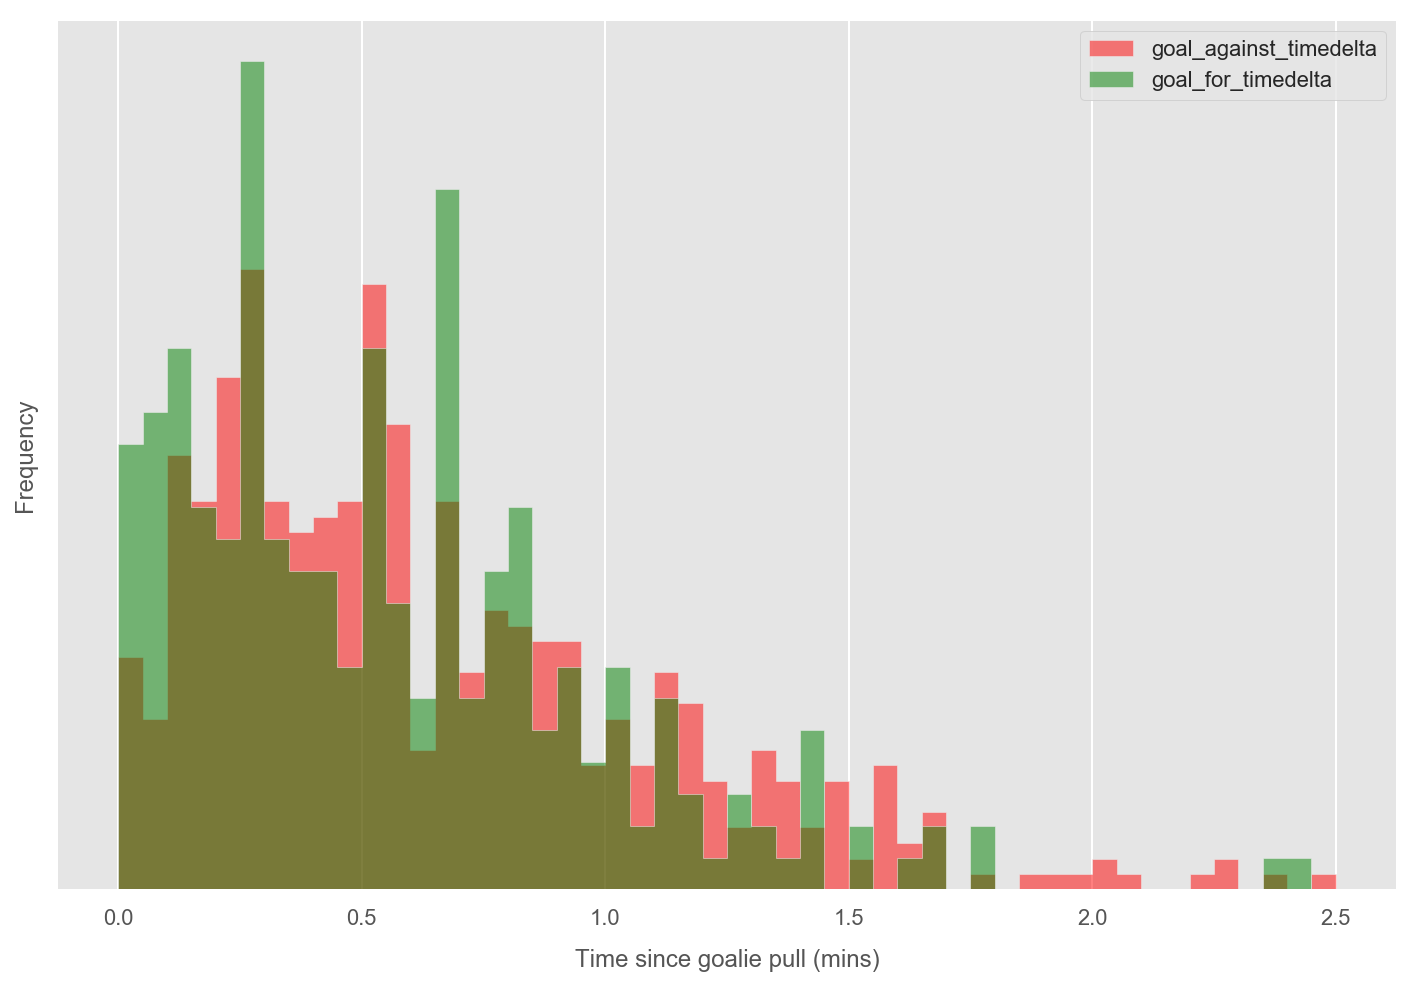

In [29]:
cols = ['goal_against_timedelta', 'goal_for_timedelta', ]
(df[cols].astype('timedelta64[s]') / 60)\
    .plot.hist(bins=50, alpha=0.5,
               density='normed',
               color=['red', 'green'],
               histtype='stepfilled')
plt.xlabel('Time since goalie pull (mins)')
plt.yticks([])
savefig(plt, '5_on_6_goalie_pull_goal_timedeltas_normed')

The mean/median number of seconds until a goal (after pulling the goalie)

In [30]:
(df[cols].astype('timedelta64[s]')).mean()

goal_against_timedelta    38.348375
goal_for_timedelta        33.525926
dtype: float64

In [31]:
(df[cols].astype('timedelta64[s]')).median()

goal_against_timedelta    31.0
goal_for_timedelta        30.0
dtype: float64

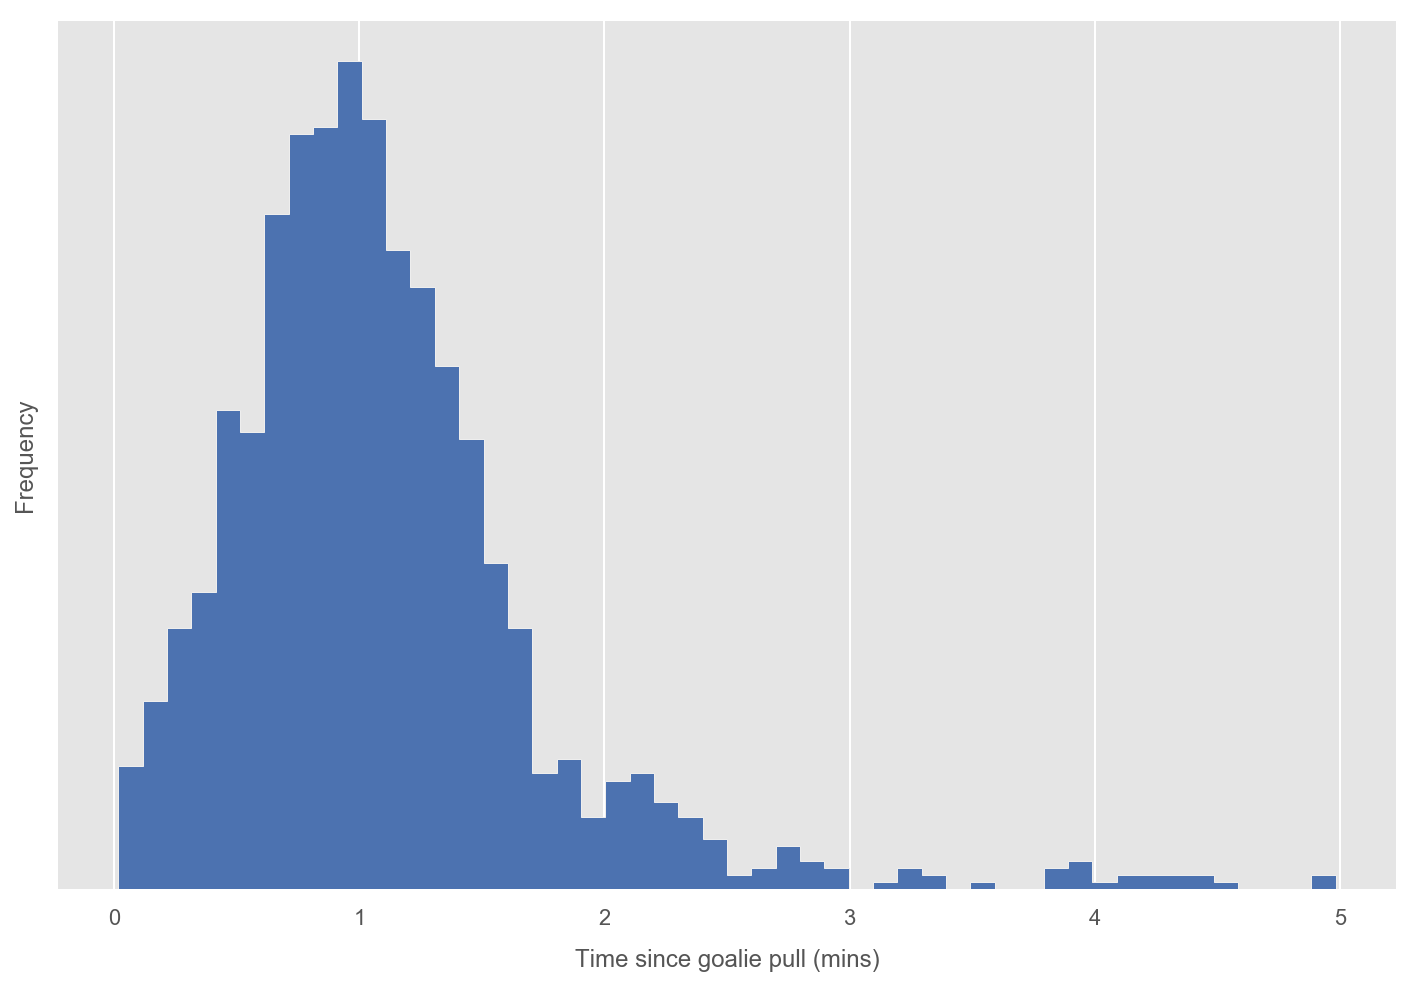

In [33]:
(df['game_end_timedelta'].astype('timedelta64[s]') / 60).plot.hist(bins=50, color='b', histtype='stepfilled')
plt.xlabel('Time since goalie pull (mins)')
plt.yticks([])
savefig(plt, '5_on_6_game_end_timedeltas')

### Rough work

### Bugs

In [247]:
df = load_data()

Any non 3rd period pulls?

In [248]:
df[df['pull_period'] != 3]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta


Any bugs not in the last 15 minutes?

In [120]:
mask = df.pull_time < datetime.timedelta(seconds=15*60)
df[mask].shape[0]

0

I noticed some goal for timedelats less than 0.. which makes no sense. I'll have to look into that

In [121]:
mask = df.goal_for_time < datetime.timedelta(seconds=15*60)
df[mask]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
576,20052006,591,NYI,2006-01-04,3,00:19:51,00:02:15,NaT,00:02:15,-1 days +23:42:24,NaT,-1 days +23:42:24


This game is weird... http://www.nhl.com/scores/htmlreports/20052006/PL020591.HTM

We'll drop this point before modeling.

In [150]:
df[df.goal_for_timedelta < datetime.timedelta(0)]

,season,game_number,team_name,date,pull_period,pull_time,goal_for_time,goal_against_time,game_end_time,goal_for_timedelta,goal_against_timedelta,game_end_timedelta
29,20032004,907,ATL,2004-02-21,3,00:19:14,00:18:59,NaT,00:20:00,-1 days +23:59:45,NaT,00:00:46
320,20032004,367,CHI,2003-12-03,3,00:18:19,00:18:01,NaT,00:19:43,-1 days +23:59:42,NaT,00:01:24
462,20032004,754,PHX,2004-01-27,3,00:19:22,00:17:52,NaT,00:19:54,-1 days +23:58:30,NaT,00:00:32
192,20062007,665,BOS,2007-01-13,3,00:17:23,00:17:13,NaT,00:19:33,-1 days +23:59:50,NaT,00:02:10


http://www.nhl.com/scores/htmlreports/20032004/PL020907.HTM

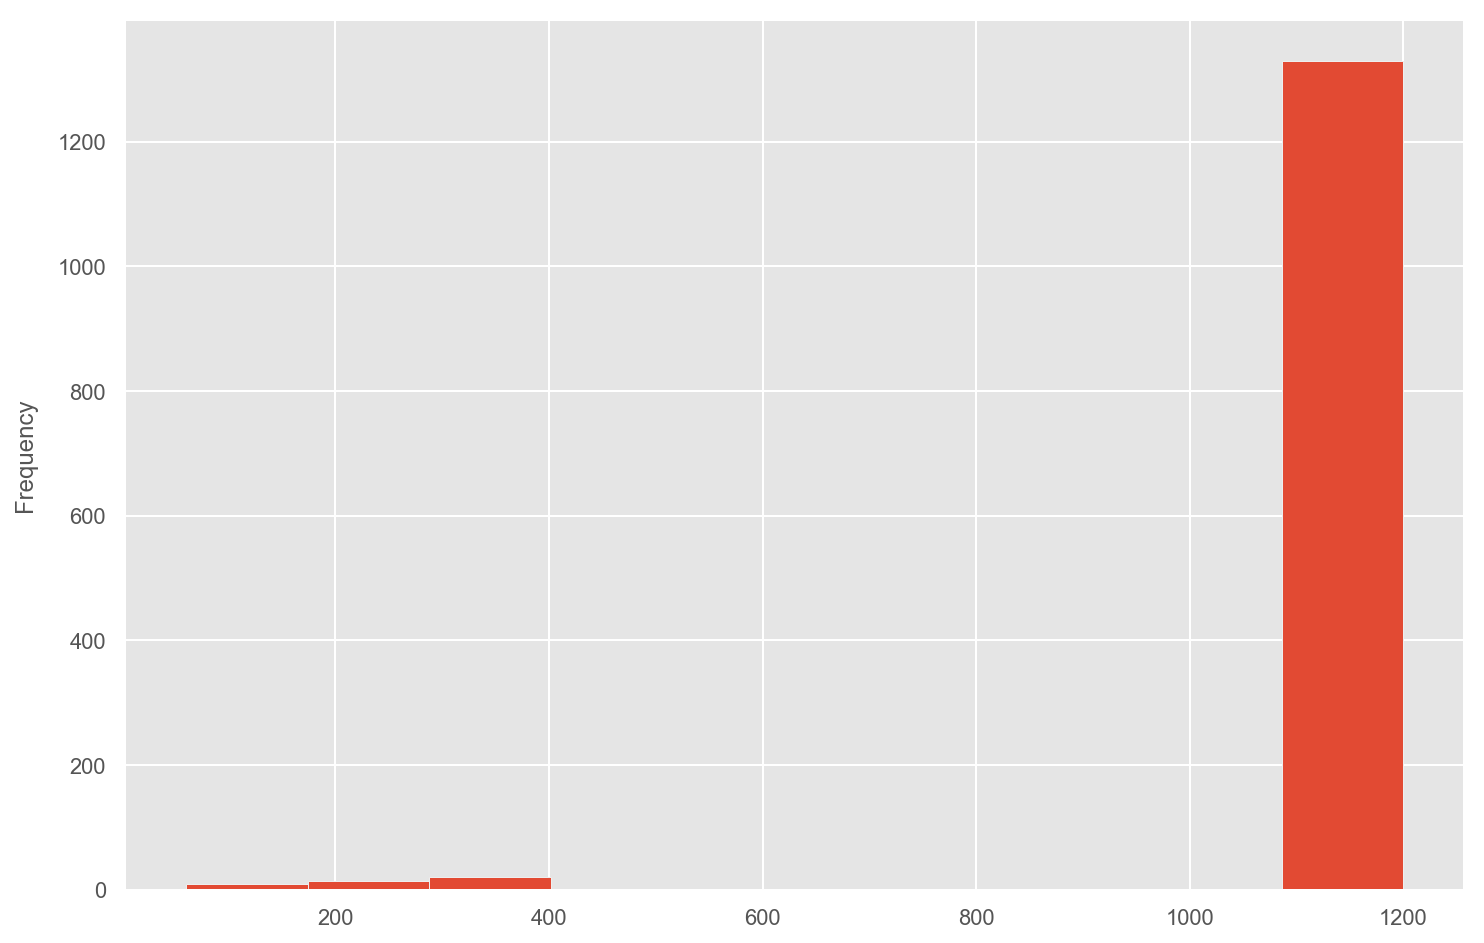

In [35]:
df.game_end_time.astype('timedelta64[s]').plot.hist()

Games should end at 20 mins. Let's throw out the early times (this must be overtime or something).

In [40]:
mask = df.game_end_time < datetime.timedelta(seconds=60*20)
mask.sum(), df.shape[0]

(1273, 2172)

In [41]:
mask = df.game_end_time < datetime.timedelta(seconds=60*15)
mask.sum(), df.shape[0]

(44, 2172)

Obviously the game will end at 20:00, this column corresponds to the last row parsed.